In [ ]:
!pip install datasets
from IPython.display import clear_output
clear_output()

# Autograd for MLPs from scratch

Automatic differentiation is the backbone of modern deep learning toolkits like Torch, JAX, TensorFlow, and MLX. To build an understanding of how these tools work, we will define functions and their gradients/Jacobians and compose them together to as the building blocks of a neural network

The gradient of a real-valued function $f:\mathbb{R}^n\to\mathbb{R}$ is a vector where
$$\nabla f(\boldsymbol{x})_{i}=\frac{\partial f(\boldsymbol{x})}{\partial x_i}$$

The Jacobian is a generalization of the gradient for a vector-valued function $f:\mathbb{R}^m\to\mathbb{R}^n$. It is a $m\times n$ matrix where
$$J_f(\boldsymbol{x})_{i,j}=\frac{\partial f(\boldsymbol{x})_i}{\partial x_j}$$

Neural nets are generally built from composed functions. To calculate the Jacobian of composed functions, we can use matrix multiplication to apply the chain rule.

$$
J_{f\circ g}(\boldsymbol{x})
= J_f(g(\boldsymbol{x}))J_g(\boldsymbol{x})
$$


In [ ]:
import jax
import jax.numpy as np
from numpy import testing
import math

def test(func, func_and_jac, *params):
  testing.assert_allclose(func(*params), func_and_jac(*params)[0])
  for i in range(len(params)):
    print(f"Testing Jacobian of parameter {i}")
    testing.assert_allclose(jax.jacfwd(func, argnums=i)(*params), func_and_jac(*params)[i + 1])
  print("All passed!")

In [ ]:
def add_and_jac(x, y):
  output = x + y
  x_jac = np.eye(math.prod(x.shape)).reshape(*x.shape, *x.shape)
  x_jac = np.broadcast_to(x_jac, (*output.shape, *x.shape))
  y_jac = np.eye(math.prod(y.shape)).reshape(*y.shape, *y.shape)
  y_jac = np.broadcast_to(y_jac, (*output.shape, *y.shape))
  return output, x_jac, y_jac

x, y = np.arange(24).reshape(2, 3, 4).astype(float)
test(np.add, add_and_jac, x, y)

Testing Jacobian of parameter 0
Testing Jacobian of parameter 1
All passed!


In [ ]:
def matmul_and_jac(x, y):
    output = np.matmul(x, y)

    m, n = x.shape
    _, p = y.shape

    x_jac = np.einsum('ik,jl->ijkl', np.eye(m), y.T)
    y_jac = np.einsum('ij,kl->ikjl', x, np.eye(p))

    return output, x_jac, y_jac

x = np.arange(12).reshape(3, 4).astype(float)
y = np.arange(20).reshape(4, 5).astype(float)
test(np.matmul, matmul_and_jac, x, y)

Testing Jacobian of parameter 0
Testing Jacobian of parameter 1
All passed!


In [ ]:
def affine(x, w, b):
  return np.dot(x, w) + b

def affine_and_jac(x, w, b):
    matmul_output, x_jac, w_jac = matmul_and_jac(x, w)
    output, add_jac1, b_jac = add_and_jac(matmul_output, b)

    return output, x_jac, w_jac, b_jac

x = np.arange(12).reshape(3, 4).astype(float)
w = np.arange(20).reshape(4, 5).astype(float)
b = np.arange(5).reshape(1, 5).astype(float)
test(affine, affine_and_jac, x, w, b)

Testing Jacobian of parameter 0
Testing Jacobian of parameter 1
Testing Jacobian of parameter 2
All passed!


In [ ]:
def relu(x):
  return np.maximum(x, 0)

def relu_and_jac(x):
    x_jac = (np.diagflat(x > 0) + np.diagflat(x == 0) / 2).reshape(*x.shape, *x.shape)
    return np.maximum(x, 0), x_jac

def logsoftmax(x):
    stabilized_x = x - np.max(x, axis=1, keepdims=True)
    return stabilized_x - np.log(np.sum(np.exp(stabilized_x), axis=1, keepdims=True))

def logsoftmax_and_jac(x):
    stabilized_x = x - np.max(x, axis=1, keepdims=True)
    softmax = np.exp(stabilized_x) / np.sum(np.exp(stabilized_x), axis=1, keepdims=True)
    logsoftmax_output = logsoftmax(x)

    n, m = x.shape
    jac = np.zeros((n, m, n, m))

    for i in range(n):
        for j in range(m):
            for k in range(m):
                if j == k:
                    jac = jac.at[i, j, i, k].set(1 - softmax[i, j])
                else:
                    jac = jac.at[i, j, i, k].set(-softmax[i, k])

    return logsoftmax_output, jac


x = np.arange(12).reshape(3, 4).astype(float)
test(logsoftmax, logsoftmax_and_jac, x)

Testing Jacobian of parameter 0
All passed!


Now that you have all the building blocks, we can compose them together to create an MLP and its Jacobian!

In [ ]:
def tree_map(func, *trees: np.ndarray | tuple[np.ndarray], **kwargs):
  if not isinstance(trees[0], tuple):
    return func(*trees, **kwargs)
  else:
    return tuple(tree_map(func, *subtrees, **kwargs) for subtrees in zip(*trees))

def sequential(func_and_jac_seq):
  def func_and_jac(x, params_seq):
    params_jac = ()
    x, x_jac, _ = add_and_jac(x, np.zeros_like(x))
    for func_and_jac, params in zip(func_and_jac_seq, params_seq):
      x, x_layer_jac, *param_layer_jacs = func_and_jac(x, *params)
      params_jac = tree_map(lambda param: np.einsum("...kl,klmn->...mn", x_layer_jac, param), params_jac)
      x_jac = np.einsum("...kl,klmn->...mn", x_layer_jac, x_jac)
      params_jac += (tuple(param_layer_jacs),)
    return x, x_jac, params_jac
  return func_and_jac

# 2-layer MLP
def mlp(x, params):
  affine1_params, _, affine2_params, _ = params
  return logsoftmax(affine(relu(affine(x, *affine1_params)), *affine2_params))

# its Jacobian!
mlp_and_jac = sequential(
    [affine_and_jac, relu_and_jac, affine_and_jac, logsoftmax_and_jac]
)

import numpy

mlp_params = (
    (
      numpy.random.randn(10,100), # first matmul
      numpy.random.randn(1, 100) # first bias
    ),
    (), # relu has no params
    (
      numpy.random.randn(100,10), # final matmul
      numpy.random.randn(1, 10) # final bias
    ),
    (), # logsoftmax has no params
)

x = numpy.random.randn(3,10)
y = np.eye(10)[numpy.random.randint(0, 10, size=3)]
print("Testing MLP Jacobian")
tree_map(
  numpy.testing.assert_allclose,
  jax.jacfwd(mlp, argnums=1)(x, mlp_params),
  mlp_and_jac(x, mlp_params)[2],
  atol=1e-5
)
print("Passed!")

Testing MLP Jacobian
Passed!


Define a loss function and its gradient, we can compose them together to get the parameter gradients of the MLP.

In [ ]:
def cross_entropy_loss(params, x, y):
  logprobs = mlp(x, params)
  return -np.mean(np.sum(logprobs * y, axis=1))

def cross_entropy_loss_and_grad(logprobs, y):
    return -np.mean(np.sum(logprobs * y, axis=1)), -y / logprobs.shape[0]

x = numpy.random.randn(3,10)
y = np.eye(10)[numpy.random.randint(0, 10, size=3)]
logprobs, x_jac, params_jac = mlp_and_jac(x, mlp_params)
loss, output_grad = cross_entropy_loss_and_grad(logprobs, y)

param_grads = tree_map(
    lambda param_jac: np.tensordot(output_grad, param_jac, axes=([0,1], [0,1])),
    params_jac
)

print("Testing MLP grad")
jax_grads = jax.grad(cross_entropy_loss)(mlp_params, x, y)
tree_map(numpy.testing.assert_allclose, param_grads, jax_grads, atol=1e-5)
print("All tests passed!")

Testing MLP grad
All tests passed!


Now that you have a taste for how autodiff works, take a look at this example, where we use JAX's autograd to do gradient descent, training an MLP to mimic a the sine function.

Epoch 0, Loss: 22.767864227294922
Epoch 1000, Loss: 0.06815874576568604
Epoch 2000, Loss: 0.02795281633734703
Epoch 3000, Loss: 0.012034187093377113
Epoch 4000, Loss: 0.0061746444553136826
Epoch 5000, Loss: 0.0037407446652650833
Epoch 6000, Loss: 0.0024744884576648474
Epoch 7000, Loss: 0.0017195675754919648
Epoch 8000, Loss: 0.0013325471663847566
Epoch 9000, Loss: 0.00105439149774611


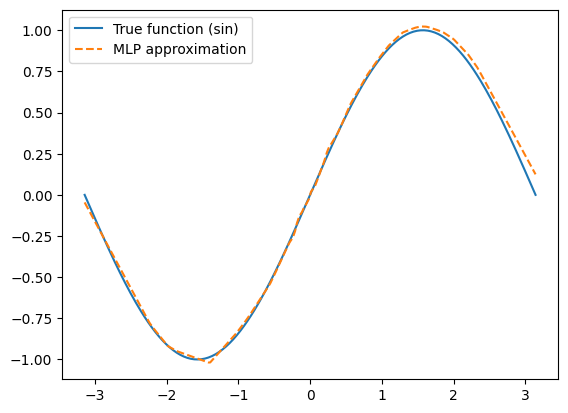

In [ ]:
# Nothing to do in this cell, just a reference implementation.

import jax.numpy as jnp
from jax import random, grad, jit
import matplotlib.pyplot as plt

# 1. Define the MLP Model
def init_mlp_params(layer_sizes, key):
    """Initialize the parameters for an MLP."""
    params = []
    keys = random.split(key, len(layer_sizes) - 1)
    for in_size, out_size, key in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        weight_key, bias_key = random.split(key)
        W = random.normal(weight_key, (in_size, out_size)) * jnp.sqrt(2.0 / in_size)
        b = jnp.zeros(out_size)
        params.append((W, b))
    return params

def mlp(params, x):
    """Forward pass for an MLP."""
    activations = x
    for W, b in params[:-1]:
        activations = jax.nn.relu(jnp.dot(activations, W) + b)
    final_W, final_b = params[-1]
    return jnp.dot(activations, final_W) + final_b

# 2. Define the loss function
def loss_fn(params, x, y):
    predictions = mlp(params, x)
    return jnp.mean((predictions - y) ** 2)

# 3. Generate data (sine function between -π and π)
key = random.PRNGKey(0)
x_train = jnp.linspace(-jnp.pi, jnp.pi, 256).reshape(-1, 1)
y_train = jnp.sin(x_train)

# 4. Initialize the model parameters
layer_sizes = [1, 64, 64, 1]  # MLP with two hidden layers
params = init_mlp_params(layer_sizes, key)

# 5. Gradient Descent update rule
learning_rate = 0.01  # Set a suitable learning rate

@jit
def update(params, x, y):
    """Performs one update step using plain gradient descent."""
    grads = grad(loss_fn)(params, x, y)  # Compute gradients
    new_params = [(W - learning_rate * dW, b - learning_rate * db)
                  for (W, b), (dW, db) in zip(params, grads)]
    return new_params

# 6. Train the model
num_epochs = 10000
for epoch in range(num_epochs):
    params = update(params, x_train, y_train)
    if epoch % 1000 == 0:
        loss = loss_fn(params, x_train, y_train)
        print(f'Epoch {epoch}, Loss: {loss}')

# 7. Plot the results
x_test = jnp.linspace(-jnp.pi, jnp.pi, 256).reshape(-1, 1)
y_pred = mlp(params, x_test)

plt.plot(x_train, y_train, label='True function (sin)')
plt.plot(x_test, y_pred, label='MLP approximation', linestyle='dashed')
plt.legend()
plt.show()

# Co-occurrence Embeddings
Consider the technique of embedding words to vectors using counts of context co-occurrences, as taught in class.

Here we will implement this technique to find embeddings for each unique word in the Shakespeare corpus. Later in the assignment, we will compare them to word embeddings learnt using Word2vec.



## Co-occurrence + PPMI

In [ ]:
# Download data - do not change
import requests
import numpy as np
from tqdm.notebook import tqdm
import time

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
response.raise_for_status() # Raise an exception for invalid HTTP status codes
text_data = response.text
len(text_data), text_data[:100]


(1115394,
 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou')

In [ ]:

# preprocessing
text_data = response.text
text_data = text_data.replace(',',' , ').replace('.',' . ').replace('?',' ? ').replace('!',' ! ')
text_data = text_data.replace('  ', ' ')
text_data = text_data.replace('\n\n','\n').replace('\n',' </s> <s> ')
text_data = '<s> ' + text_data + ' </s>'
len(text_data), text_data[:100]

(1451204,
 '<s> First Citizen: </s> <s> Before we proceed any further , hear me speak .  </s> <s> All: </s> <s> ')

In [ ]:
data = text_data.split(' ')
vocab = list(set(data))
word_to_idx = {v:k for k,v in enumerate(vocab)} # dictionary to map words to indices


In [ ]:
counts = np.zeros(shape=(len(vocab), len(vocab)))
assert counts.shape == (18118, 18118)

span_length = 5
start_time = time.time()

for i,w in tqdm(enumerate(data), total=len(data)):
    start = max(0, i - span_length)
    end = min(len(data), i + span_length + 1)
    context = data[start:i] + data[i+1:end]
    for c in context:
        counts[word_to_idx[w], word_to_idx[c]] += 1

total_count = np.sum(counts)
word_freqs = np.sum(counts, axis=1)
context_freqs = np.sum(counts, axis=0)

expected = np.outer(word_freqs, context_freqs) / total_count
pmi = np.log(counts / expected)
ppmi = np.maximum(pmi, 0)

ppmi_norms = np.linalg.norm(ppmi, axis=1)

print("--- %s seconds ---" % (time.time() - start_time))

assert ppmi.shape == (len(vocab), len(vocab))
assert counts[word_to_idx['First'],word_to_idx['Citizen:']] == 44.
np.testing.assert_allclose(ppmi[word_to_idx['First'],word_to_idx['Citizen:']], 4.024266, rtol=1e-3)

  0%|          | 0/316243 [00:00<?, ?it/s]

<ipython-input-13-99c03e995e82>:23: RuntimeWarning: divide by zero encountered in log
  pmi = np.log(counts / expected)


--- 22.3142569065094 seconds ---


## Nearest Neighbours

In [ ]:
def get_nearest_neighbours(word_or_vector, vectors=ppmi, top_k=5, vocab=vocab,
                           norms=ppmi_norms):
    if isinstance(word_or_vector, str):
        word_index = vocab.index(word_or_vector)
        target_vector = vectors[word_index]
    else:
        target_vector = word_or_vector

    target_norm = np.linalg.norm(target_vector)
    if target_norm != 0:
        target_vector = target_vector / target_norm

    similarities = np.dot(vectors, target_vector) / norms

    top_indices = np.argsort(similarities)[::-1][:top_k]

    nearest_neighbours = [vocab[i] for i in top_indices]

    return nearest_neighbours

In [ ]:
get_nearest_neighbours('he')
print(get_nearest_neighbours('he'))
assert 'he' in get_nearest_neighbours('he')

['he', 'hath', 'his', 'is', 'that']


Here we will evaluate the embeddings on Analogy Task.


In [ ]:
# Download and preprocessing data
import requests
import numpy as np
from tqdm.notebook import tqdm

url = "http://download.tensorflow.org/data/questions-words.txt"
response = requests.get(url)
response.raise_for_status() # Raise an exception for invalid HTTP status codes
analogy = response.text.split('\n')

# filtering out analogies that do not exist in our vocabulary
task = []
for line in tqdm(analogy, total=len(analogy)):
  row = line.split(' ')
  if len(row) != 4 or line.startswith(':'):
    continue
  if sum(_ in vocab for _ in row) == 4:
    task.append(row)
len(task), task[-1]

  0%|          | 0/19559 [00:00<?, ?it/s]

(2396, ['write', 'writes', 'work', 'works'])

In [ ]:
# Inference over Analogy Benchmark - do not change
start_time = time.time()
acc = 0.
for a,b,c,d in tqdm(task[:50]): # Note down this Inference Time
  d_ = get_nearest_neighbours(
        word_or_vector=ppmi[word_to_idx[a]]+ppmi[word_to_idx[b]]-ppmi[word_to_idx[c]],
        top_k=100
      )
  if d in d_:
    acc += 1
print('inference time:', time.time() - start_time)
acc/len(task)

  0%|          | 0/50 [00:00<?, ?it/s]

inference time: 12.685454845428467


0.00041736227045075126

# Word2vec Gradient Derivation

Given the target word embedding $w$, context word embedding $c_\text{pos}$ from positive examples, and $K$ noise word embeddings $c_\text{neg$_i$}$ from negative examples,

$L = - [\log \sigma(w.c_\text{pos})+\Sigma_{i=1..K} \log \sigma(-w.c_\text{neg$_i$})]$

where $\sigma$ is the sigmoid function.

## Derive the following gradients.

$ \sigma(x) = \frac{1}{1 + e^{-x}} $


$\frac{\partial \sigma(x)}{\partial x} = \frac{\partial}{\partial x} \left( \frac{1}{1 + e^{-x}} \right)$


Using the quotient rule for differentiation:

$ \frac{\partial}{\partial x} \left( \frac{1}{f(x)} \right) = -\frac{f'(x)}{(f(x))^2} $

$\frac{\partial \sigma(x)}{\partial x} = -\frac{-e^{-x}}{(1 + e^{-x})^2} = \frac{e^{-x}}{(1 + e^{-x})^2}$

$\sigma(x) = \frac{1}{1 + e^{-x}} \implies e^{-x} = \frac{1 - \sigma(x)}{\sigma(x)}$

Substitute this into the derivative:

$
\frac{\partial \sigma(x)}{\partial x} = \frac{\sigma(x)(1 - \sigma(x))}{\sigma(x)^2} \cdot \sigma(x) = \sigma(x)(1 - \sigma(x))
$




$\frac{\partial \sigma(x)}{\partial x} = \sigma(x)(1 - \sigma(x))$

---

### $\frac{∂ L}{∂ w}$

#### For $w \cdot c_{pos}$:
The first term in $L$ is $\log \sigma(w \cdot c_{pos})$, so the gradient of this term with respect to $w$ is:

$
\frac{\partial}{\partial w} \log \sigma(w \cdot c_{pos}) = \frac{1}{\sigma(w \cdot c_{pos})} \cdot \frac{\partial}{\partial w} \sigma(w \cdot c_{pos})
$

Using the derivative of the sigmoid function, $\frac{\partial \sigma(x)}{\partial x} = \sigma(x)(1 - \sigma(x))$, we get:

$
\frac{\partial}{\partial w} \log \sigma(w \cdot c_{pos}) = (1 - \sigma(w \cdot c_{pos})) \cdot c_{pos}
$

#### For $w \cdot c_{neg_i}$:
The second term is the sum over the negative samples. The gradient of the $i$-th term in the sum is:

$
\frac{\partial}{\partial w} \log \sigma(-w \cdot c_{neg_i}) = \frac{1}{\sigma(-w \cdot c_{neg_i})} \cdot \frac{\partial}{\partial w} \sigma(-w \cdot c_{neg_i})
$

Again, using the derivative of the sigmoid function:

$
\frac{\partial}{\partial w} \log \sigma(-w \cdot c_{neg_i}) = -\sigma(-w \cdot c_{neg_i})(1 - \sigma(-w \cdot c_{neg_i})) \cdot (-c_{neg_i}) = \sigma(-w \cdot c_{neg_i}) \cdot c_{neg_i}
$

Summing over all $K$ negative samples, we get:

$
\frac{\partial}{\partial w} \sum_{i=1}^{K} \log \sigma(-w \cdot c_{neg_i}) = \sum_{i=1}^{K} \sigma(w \cdot c_{neg_i}) \cdot c_{neg_i}
$

Thus, the total gradient with respect to $w$ is:

$
\frac{\partial L}{\partial w} = -(1 - \sigma(w \cdot c_{pos})) \cdot c_{pos} + \sum_{i=1}^{K} \sigma(w \cdot c_{neg_i}) \cdot c_{neg_i}
$

---

### $\frac{∂ L}{∂ c_\text{pos}}$


$ \frac{\partial}{\partial c_{neg_i}} \log \sigma(-w \cdot c_{neg_i}) = \sigma(w \cdot c_{neg_i}) \cdot w $

Thus, the gradient with respect to $c_{neg_i}$ is:

$ \frac{\partial L}{\partial c_{neg_i}} = \sigma(w \cdot c_{neg_i}) \cdot w $


---

### Final Gradients:

1. $\frac{\partial L}{\partial w} = -(1 - \sigma(w \cdot c_{pos})) \cdot c_{pos} + \sum_{i=1}^{K} \sigma(w \cdot c_{neg_i}) \cdot c_{neg_i}$
2. $\frac{\partial L}{\partial c_{pos}} = -(1 - \sigma(w \cdot c_{pos})) \cdot w$
3. $\frac{\partial L}{\partial c_{neg_i}} = \sigma(w \cdot c_{neg_i}) \cdot w$


## How do embeddings change when updated using SGD under the gradients above.

The goal of the embedding is to make the embedding of similar words close to each other (or similar to each other) ad differentiate dissimilar words. So when a positive example is being considered, given a context word $c$ and target word $w$, the final true output is a one hot encoded vector where the value corresponding to $w$ is 1 and rest all values are 0. So the loss function is calculate with the softmax values and are correspondingly updated through backward propagation. They are updated in a such way that the embedding of the context word $c$ moves closer to the embedding of the word $w$. In case of negative sampling, the embedding of $c_{neg}$ is updated in such a way that it moves away from the embeding of $w$.

## Why is negative sampling required? What happens if we solely rely on positive examples?

Negative sampling is needed to reduce computation. There are parameters of the dimensions of embeddings*vocabulary. In most cases the vocabulary is very big, making the calculation of the softmax and backward propagation very expensive. Therefore by adding negative samples, we only update the weights of the corresponding weights of the positive and negative samples instead of all the weights.

If we solely rely on positive samples, the model doesn't learn what incorrect or irrelevant word pairs look like. This may cause the model to overfit.Also, without negative examples, the embeddings might not effectively capture the nuances between similar and dissimilar words because the model isn't penalized for producing similar embeddings for unrelated words.

# Learn Word2Vec Embeddings

## Learning Word2vec

Using a span length of `5` words on each side (total window length 11), `50` dimensions per embeddings, `0.01` learning rate, `15` negative samples per target word, and `500_000` number of iterations or training updates, we train the word2vec embeddings.




In [ ]:
import scipy.special
import numpy as np

D = 50 # embedding_dimensions
w_vectors = np.random.rand(len(vocab), D) # target
c_vectors = np.random.rand(len(vocab), D) # context and noise

In [ ]:
start_time = time.time()
alpha = 0.01
K = 15
span_length = 5
num_iter = 500_000

losses = []
for iter in tqdm(range(num_iter)): # # Note down this Training Time
    t_idx = np.random.randint(span_length, len(data) - span_length)
    t = word_to_idx[data[t_idx]]

    left_context = data[t_idx - span_length:t_idx]
    right_context = data[t_idx + 1:t_idx + span_length + 1]

    context_indices = np.concatenate((left_context, right_context))

    for c in context_indices:
        c = word_to_idx[c]

        v_t = w_vectors[t]
        u_c = c_vectors[c]

        s_pos = scipy.special.expit(np.dot(u_c, v_t))
        e_pos = s_pos - 1

        grad_v_t = e_pos * u_c
        grad_u_c = e_pos * v_t

        L_pos = -np.log(s_pos + 1e-10)

        negative_indices = np.random.randint(0, len(vocab), size=K)
        u_neg = c_vectors[negative_indices]

        s_neg = scipy.special.expit(u_neg @ v_t)
        e_neg = s_neg

        grad_v_t_neg = np.sum(e_neg[:, np.newaxis] * u_neg, axis=0)
        grad_u_neg = e_neg[:, np.newaxis] * v_t

        L_neg = -np.sum(np.log(1 - s_neg + 1e-10))

        L = L_pos + L_neg
        losses.append(L)

        v_t -= alpha * (grad_v_t + grad_v_t_neg)
        u_c -= alpha * grad_u_c

        np.add.at(c_vectors, negative_indices, -alpha * grad_u_neg)

        w_vectors[t] = v_t
        c_vectors[c] = u_c
    if iter%10_000 == 0:
        print(f"Loss at epoch: {iter}: {sum(losses)/len(losses)}") # This should go down as training proceeds
        losses = [] # resetting log every 10K steps

print('training time:', time.time()-start_time)

  0%|          | 0/500000 [00:00<?, ?it/s]

Loss at epoch: 0: 72.47227917908141
Loss at epoch: 10000: 18.668205766592212
Loss at epoch: 20000: 11.151958448167708
Loss at epoch: 30000: 8.81871880668026
Loss at epoch: 40000: 7.903026076816959
Loss at epoch: 50000: 6.956598454250675
Loss at epoch: 60000: 6.123476688037418
Loss at epoch: 70000: 5.7444319001469974
Loss at epoch: 80000: 5.577495049029356
Loss at epoch: 90000: 5.175850350844547
Loss at epoch: 100000: 4.631961338331311
Loss at epoch: 110000: 4.603214944080818
Loss at epoch: 120000: 4.0238777130716725
Loss at epoch: 130000: 4.164559740377783
Loss at epoch: 140000: 4.189490076509229
Loss at epoch: 150000: 3.854644637520613
Loss at epoch: 160000: 3.6498965508023673
Loss at epoch: 170000: 3.5354685367834677
Loss at epoch: 180000: 3.343100288327078
Loss at epoch: 190000: 3.4246649457143037
Loss at epoch: 200000: 3.477147885982822
Loss at epoch: 210000: 3.1582816966260765
Loss at epoch: 220000: 3.216887965799629
Loss at epoch: 230000: 3.057737233236426
Loss at epoch: 240000: 

In [ ]:
w_vectors_norms = np.linalg.norm(w_vectors, axis=1)
c_vectors_norms = np.linalg.norm(c_vectors, axis=1)

In [ ]:
get_nearest_neighbours('First', vectors=w_vectors, top_k=5, vocab=vocab,
                       norms=w_vectors_norms)

['First', '</s>', '<s>', '', '.']

In [ ]:
get_nearest_neighbours('First', vectors=c_vectors, top_k=5, vocab=vocab,
                       norms=c_vectors_norms)

['First', 'LEONTES:', 'ARIEL:', 'III:', 'DUCHESS']

In [ ]:
# evaluation - do not change
start_time = time.time()
hit_at_k = 0.
for a,b,c,d in tqdm(task): # Note down this Inference Time
  d_ = get_nearest_neighbours(
        word_or_vector=w_vectors[word_to_idx[a]]+w_vectors[word_to_idx[b]]-w_vectors[word_to_idx[c]],
        top_k=100,
        vectors=w_vectors,
        norms=w_vectors_norms,
      )
  # Note that we could have used c_vectors as well instead of w_vectors
  if d in d_:
    hit_at_k += 1
hit_at_k/=len(task)
print('inference time:', time.time() - start_time)
print(hit_at_k)

  0%|          | 0/2396 [00:00<?, ?it/s]

inference time: 9.677460670471191
0.012103505843071787


## Comparison of embeddings

We have trained two variants of embeddings, we can compare their results in terms of:
- Analogy Task Hit@100 scores
- Training and Inference Speed (time taken)
- Memory Requirement


In [ ]:
import sys
print("size of ppmi vector embeddings in MBs: ", sys.getsizeof(ppmi) / 1024 / 1024)
print("size of word2vec vector embeddings in MBs: ", sys.getsizeof(w_vectors) / 1024 / 1024)

size of ppmi vector embeddings in MBs:  2504.4398498535156
size of word2vec vector embeddings in MBs:  6.911590576171875




Method|Training Speed|Inference Speed|Memory|Analogy
---|---|---|---|---
PPMI|22.314 secs|12.685 secs|2504.44 MB|0.00041
SGNS|628.064 secs|9.677 secs|6.911 MB|0.012

## Difference in Results

Hypothesizing the cause of the differences in training speed, inference speed, memory, and analogy results between the two methods.


1. **Training Speed**:
   PPMI is faster to train because it relies on a co-occurrence matrix and counts, which are quickly calculated using matrix factorization techniques. Once the matrix is built, embeddings can be derived efficiently. SGNS, on the other hand, is trained using stochastic gradient descent (SGD) over many iterations and uses negative sampling to optimize the embeddings. This process slows down training as compared to PPMI.

2. **Inference Speed**:
   PPMI has slower inference speed because it computes similarities based on the dense, large co-occurrence matrix. PPMI embeddings are often dense and high-dimensional and hence calculating similarities becomes slower. SGNS generates embeddings directly during training and the vectors produced by SGNS are lower-dimensional, resulting in faster inference speed.

3. **Memory Usage**:
   PPMI requires storing a large co-occurrence matrix, which consumes more memory, especially for large vocabularies. This matrix is dense and can occupy significant space. SGNS uses sparse representations and negative sampling, which reduces the need for storing large matrices. The model only keeps word vectors and context vectors, making it much more memory-efficient.

4. **Analogy Results**:
   SGNS performs better on analogy tasks because it optimizes word vectors to capture relationships through context-based learning and negative sampling, which helps in capturing semantic regularities.On the other hand, PPMI uses statistical information (co-occurrence counts) that does not directly optimize for such semantic relationships, leading to poorer performance in analogy tests.



# Context Aware Embeddings using Self-Attention

## Self-Attention

Self-Attention is a type of a scaled dot-product attention. It allows the model to weigh different positions of a sequence differently when constructing a representation of that sequence. This is crucial in NLP tasks because it enables the model to focus on relevant parts of a sentence, regardless of their position in the sequence.

Given an input sequence with $n$ tokens, each token is first converted into an embedding vector. Let's denote these embeddings as $\mathbf{X} \in \mathbb{R}^{n \times d_{\text{model}}}$, where $d_{\text{model}}$ is the dimension of the embeddings.

For each token, we compute three vectors: Query ($\mathbf{Q}$), Key ($\mathbf{K}$), and Value ($\mathbf{V}$). These vectors are obtained by multiplying the input embeddings by three learnable weight matrices:

$$
\mathbf{Q} = \mathbf{X}\mathbf{W}_Q, \quad \mathbf{K} = \mathbf{X}\mathbf{W}_K, \quad \mathbf{V} = \mathbf{X}\mathbf{W}_V
$$

where:

*  $\mathbf{W}_Q \in \mathbb{R}^{d_{\text{model}} \times d_k}$,
*  $\mathbf{W}_K \in \mathbb{R}^{d_{\text{model}} \times d_k}$
*  $\mathbf{W}_V \in \mathbb{R}^{d_{\text{model}} \times d_v}$

$d_k$ and $d_v$ are the dimensions of the Query/Key and Value vectors, respectively.

The attention mechanism calculates the attention scores between the Query and Key vectors to determine how much focus should be placed on different tokens in the sequence.

The attention scores are computed using the dot product of the Query and Key vectors, scaled by the square root of the dimension of the Key vectors $d_k$:

$$
\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{d_k}}\right)\mathbf{V}
$$

Here:

* $\mathbf{Q}\mathbf{K}^\top$ gives the similarity scores between the Query and Key vectors.
* $\frac{1}{\sqrt{d_k}}$ is a scaling factor to prevent the dot products from growing too large, which could lead to very small gradients.
* The softmax function normalizes the scores so that they sum to 1.
* The resulting matrix is then multiplied by the Value matrix $\mathbf{V}$ to produce the output.



In [ ]:
import numpy as np

from abc import ABC, abstractmethod

class NNComp(ABC):
    @abstractmethod
    def forward(self, x):
        pass

    @abstractmethod
    def backward(self, incoming_grad):
        pass


class Linear(NNComp):
    def __init__(self, in_dim, out_dim):
        k = 1 / in_dim
        self.in_dim = in_dim
        self.out_dim = out_dim

        # initialize the weights and the bias
        self.weight = np.random.uniform(-np.sqrt(k), np.sqrt(k), size=(in_dim, out_dim))
        self.bias = np.random.uniform(-np.sqrt(k), np.sqrt(k), size=out_dim)

        # backward prop
        self.backward_context = None
        self.dweight = np.empty_like(self.weight, dtype=float)
        self.dbias = np.empty_like(self.bias, dtype=float)

    def forward(self, x):
        assert np.shape(x)[-1] == self.in_dim
        self.backward_context = x
        return x @ self.weight + self.bias

    def backward(self, incoming_grad):
        self.dweight = self.backward_context.T @ incoming_grad
        self.dbias = incoming_grad.sum(axis=0)
        return incoming_grad @ self.weight.T

    def update_parameters(self, lr):
        self.weight -= lr * self.dweight
        self.bias -= lr * self.dbias


class LogSoftmax(NNComp):
    def __init__(self):
        self.backward_context = None

    def forward(self, x):
        self.backward_context = x - np.max(x, axis=-1, keepdims=True)
        return self.backward_context - np.log(np.exp(self.backward_context).sum(axis=-1, keepdims=True))

    def backward(self, incoming_grad):
        softmax = np.exp(self.backward_context) / np.exp(self.backward_context).sum(axis=-1, keepdims=True)
        return incoming_grad - softmax * incoming_grad.sum(axis=-1, keepdims=True)

## Implementing the Self-Attention Module

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
class SelfAttention(NNComp):
    def __init__(self, embed_dim):
        self.embed_dim = embed_dim # Specify the embedding dimension

        # Initializer Q, K, V vectors
        self.query_layer = Linear(embed_dim, embed_dim)
        self.key_layer = Linear(embed_dim, embed_dim)
        self.value_layer = Linear(embed_dim, embed_dim)
        self.softmax = LogSoftmax()

        self.backward_context = None

    def forward(self, x):
        # Setting up the Q, K, V vectors
        Q = self.query_layer.forward(x)
        K = self.key_layer.forward(x)
        V = self.value_layer.forward(x)

        # Compute attention scores
        scores = Q @ K.T / np.sqrt(self.embed_dim)

        # Normalize scores using LogSoftmax and exponentiate to get attention weights
        log_attention_weights = self.softmax.forward(scores)
        attention_weights = np.exp(log_attention_weights)

        # Compute the output by weighting V with attention weights
        output = attention_weights @ V

        # Store variables needed for backward pass
        self.backward_context = {
            'Q': Q,
            'K': K,
            'V': V,
            'attention_weights': attention_weights,
            'x': x
        }

        return output

    def backward(self, incoming_grad):

        Q = self.backward_context['Q']
        K = self.backward_context['K']
        V = self.backward_context['V']
        attention_weights = self.backward_context['attention_weights']
        x = self.backward_context['x']

        # Gradient w.r.t V
        grad_V = attention_weights.T @ incoming_grad

        # Gradient w.r.t attention weights
        grad_attention_weights = incoming_grad @ V.T

        # Gradient w.r.t scores via LogSoftmax backward pass
        grad_log_attention_weights = grad_attention_weights * attention_weights
        grad_scores = self.softmax.backward(grad_log_attention_weights)

        # Scale factor for attention scores
        scale = 1 / np.sqrt(self.embed_dim)

        # Gradients w.r.t Q and K
        grad_Q = grad_scores @ K * scale
        grad_K = grad_scores.T @ Q * scale

        # Backpropagate through linear layers
        grad_x_query = self.query_layer.backward(grad_Q)
        grad_x_key = self.key_layer.backward(grad_K)
        grad_x_value = self.value_layer.backward(grad_V)

        # Total gradient w.r.t input x
        grad_x = grad_x_query + grad_x_key + grad_x_value

        return grad_x

    def update_parameters(self, lr):
        self.query_layer.update_parameters(lr)
        self.key_layer.update_parameters(lr)
        self.value_layer.update_parameters(lr)

## Training Self-Attention Module

We will use the word embeddings developed in word2vec and apply Self-Attention on them to obtain **contextual embeddings**.

Contextual embeddings, like those from BERT or GPT, capture the meaning of a word based on the context in which it appears, producing different embeddings for the same word in different contexts. In contrast, Word2Vec generates static embeddings, where each word has a single fixed vector representation regardless of its context.

For this, we will use the dataset from the [SuperGLUE Benchmark](https://super.gluebenchmark.com/) called 'Words in Context' (WiC [link text](https://aclanthology.org/N19-1128/)). This task evaluates settings where the "context" of the word is important to infer its meaning -- for example, the meaning of the word "bank" changes when used in context of money or a river.

This dataset comprises of a pair of sentences, and a binary label. The label is 1 if a target word is used in the same context, and 0 otherwise. See examples below.

In [ ]:
from datasets import load_dataset

# Load the SuperGLUE WiC dataset
dataset = load_dataset('super_glue', 'wic', trust_remote_code=True)

# Extract the training and testing data
train_data = dataset['train']
test_data = dataset['validation']

# Prepare sentences and labels
sentences_1_train = train_data['sentence1']
sentences_2_train = train_data['sentence2']
labels_train = train_data['label']

sentences_1_test = test_data['sentence1']
sentences_2_test = test_data['sentence2']
labels_test = test_data['label']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


super_glue.py:   0%|          | 0.00/30.7k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/18.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5428 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/638 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1400 [00:00<?, ? examples/s]

In [ ]:
# Example of an instance where the meaning of the word "place" is not the same
sentences_1_train[0], sentences_2_train[0], labels_train[0]

('Do you want to come over to my place later?',
 'A political system with no place for the less prominent groups.',
 0)

In [ ]:
# Example of an instance where the meaning of the word "summer" is the same
sentences_1_train[4], sentences_2_train[4], labels_train[4]

('We like to summer in the Mediterranean.', 'We summered in Kashmir.', 1)

Given this dataset, you first need to train a Self-Attention Model over the word2vec embeddings, to better learn the context and position of words on this dataset.

For training self-attention, we will make use of a Binary Cross Entropy Loss. First, we perform a forward pass through the self-attention model for both sentences:

$$
\text{output}_1 = \text{AttentionModel}(\text{emb}_1) \quad \text{and} \quad \text{output}_2 = \text{AttentionModel}(\text{emb}_2)
$$

These outputs are the contextual embeddings for the first and second sentences, respectively.

Next, we compute the similarity score between the two outputs using cosine similarity:

$$
\text{similarity} = \frac{\text{output}_1 \cdot \text{output}_2}{\|\text{output}_1\| \|\text{output}_2\|}
$$

We then apply the sigmoid function to this similarity score to obtain a predicted probability:

$$
\text{predicted} = \frac{1}{1 + e^{-\text{similarity}}}
$$

Given a target label $\text{target} \in \{0, 1\}$, we compute the Binary Cross-Entropy Loss:

$$
\text{loss} = - \left( \text{target} \cdot \log(\text{predicted} + 10^{-10}) + (1 - \text{target}) \cdot \log(1 - \text{predicted} + 10^{-10}) \right)
$$

Note that we add $10^{-10}$ for stability in log, during training.

The gradient of the loss with respect to the predicted output is:

$$
\text{grad_loss} = \text{predicted} - \text{target}
$$

Finally, we backpropagate the gradients through the attention model for both embeddings.


In [ ]:
def normalize_embeddings(embeddings):
  mean = np.mean(embeddings, axis=0)
  std = np.std(embeddings, axis=0)
  return (embeddings - mean) / (std + 1e-8)

def extract_w2v_embeddings(sentences, max_tokens=10):
  embeddings = []
  for sentence in sentences:
    w2v_embeddings_sentence = []
    words = sentence.split()

    for word in words:
      if word in word_to_idx:
        w2v_embeddings_sentence.append(w_vectors[word_to_idx[word]])

    if len(w2v_embeddings_sentence) < max_tokens:
      pad_tokens = max_tokens - len(w2v_embeddings_sentence)
      w2v_embeddings_sentence.extend([np.zeros(D) for i in range(pad_tokens)])
    else:
      w2v_embeddings_sentence = w2v_embeddings_sentence[:max_tokens]

    embeddings.append(np.array(w2v_embeddings_sentence))

  return embeddings

input_embeddings_1 = extract_w2v_embeddings(sentences_1_train)
input_embeddings_2 = extract_w2v_embeddings(sentences_2_train)

In [ ]:
lr = 1e-5
epochs = 10

attention_model = SelfAttention(D)

for epoch in range(epochs):
    total_loss = 0
    for i, (emb1, emb2) in enumerate(zip(input_embeddings_1, input_embeddings_2)):
        # Forward pass through self-attention model for both sentences
        emb1 = np.array(emb1)
        emb2 = np.array(emb2)
        max_tokens = emb1.shape[0]
        out1 = attention_model.forward(emb1)
        out2 = attention_model.forward(emb2)
        sent_repr1 = np.mean(out1, axis=0)
        sent_repr2 = np.mean(out2, axis=0)

        # Compute similarity score between the two outputs (e.g., cosine similarity)
        dot_product = np.dot(sent_repr1, sent_repr2)
        norm1 = np.linalg.norm(sent_repr1)
        norm2 = np.linalg.norm(sent_repr2)
        cosine_similarity = dot_product / (norm1 * norm2 + 1e-8)

        pred = 1 / (1 + np.exp(-cosine_similarity))

        # Define target (either 0 or 1)
        target = labels_train[i]

        # Compute Binary Cross-Entropy Loss
        epsilon = 1e-8  # To avoid log(0)
        loss = - (target * np.log(pred + epsilon) + (1 - target) * np.log(1 - pred + epsilon))
        total_loss += loss

        # Compute gradient of the loss w.r.t. predicted output
        d_pred = - (target / (pred + epsilon)) + ((1 - target) / (1 - pred + epsilon))

        # Gradient through sigmoid
        d_cosine_similarity = d_pred * pred * (1 - pred)

        # Compute gradients w.r.t. sentence representations
        d_sent_repr1 = (d_cosine_similarity / (norm1 * norm2 + 1e-8)) * (sent_repr2 - (dot_product / (norm1 ** 2 + 1e-8)) * sent_repr1)
        d_sent_repr2 = (d_cosine_similarity / (norm1 * norm2 + 1e-8)) * (sent_repr1 - (dot_product / (norm2 ** 2 + 1e-8)) * sent_repr2)

        d_out1 = (1 / max_tokens) * np.tile(d_sent_repr1, (emb1.shape[0], 1))
        d_out2 = (1 / max_tokens) * np.tile(d_sent_repr2, (emb2.shape[0], 1))

        # Backpropagate the gradients through the attention model for both embeddings
        attention_model.backward(d_out1)
        attention_model.backward(d_out2)

        # Update parameters
        attention_model.update_parameters(lr)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(input_embeddings_1)}")

Epoch 1/10, Loss: 0.7855745244128801
Epoch 2/10, Loss: 0.7853744997547337
Epoch 3/10, Loss: 0.7851718979900115
Epoch 4/10, Loss: 0.7849666710929156
Epoch 5/10, Loss: 0.7847587698915945
Epoch 6/10, Loss: 0.7845481440364491
Epoch 7/10, Loss: 0.7843347419674858
Epoch 8/10, Loss: 0.7841185108808013
Epoch 9/10, Loss: 0.7838993966940931
Epoch 10/10, Loss: 0.7836773440111856


## Word2vec vs. Contextual Embeddings

We will now compare word2vec embeddings and the contextual embeddings we just made on the WiC task from above.

In [ ]:
# get_sentence_embeddings is a general purpose function that will create sentence embeddings given any type of embeddings
def get_sentence_embeddings(sentences, attention_model=None):
  feature_matrix = np.zeros((len(sentences), D))

  for i, sentence in enumerate(sentences):
    words = sentence.split()

    # We only look for words that occur in our vocabulary (specially since we are using a different dataset to build the vocabulary)
    word_indices = [word_to_idx[word] for word in words if word in word_to_idx]

    # Sentence embeddings are created by aggregating the word embeddings obtained
    if word_indices:
      word_embeddings = w_vectors[word_indices, :]
      if attention_model:
        word_embeddings = attention_model.forward(word_embeddings)
      feature_matrix[i] = np.mean(word_embeddings, axis=0)
    else:
      feature_matrix[i] = np.zeros(D)

  return feature_matrix

In [ ]:
# Extract features for both sets of sentences in training and testing
features_1_train_word2vec = get_sentence_embeddings(sentences_1_train)
features_2_train_word2vec = get_sentence_embeddings(sentences_2_train)
features_1_test_word2vec = get_sentence_embeddings(sentences_1_test)
features_2_test_word2vec = get_sentence_embeddings(sentences_2_test)

# Same for contextual embeddings
features_1_train_contextual = get_sentence_embeddings(sentences_1_train, attention_model=attention_model)
features_2_train_contextual = get_sentence_embeddings(sentences_2_train, attention_model=attention_model)
features_1_test_contextual = get_sentence_embeddings(sentences_1_test, attention_model=attention_model)
features_2_test_contextual = get_sentence_embeddings(sentences_2_test, attention_model=attention_model)

In [ ]:
import numpy as np

# Combine the features from both sentences for the classifier input
X_train_word2vec = np.concatenate([features_1_train_word2vec, features_2_train_word2vec], axis=1)
X_test_word2vec = np.concatenate([features_1_test_word2vec, features_2_test_word2vec], axis=1)

X_train_contextual = np.concatenate([features_1_train_contextual, features_2_train_contextual], axis=1)
X_test_contextual = np.concatenate([features_1_test_contextual, features_2_test_contextual], axis=1)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train classifier on word2vec embeddings
clf_word2vec = LogisticRegression(max_iter=1000)
clf_word2vec.fit(X_train_word2vec, labels_train)
pred_word2vec = clf_word2vec.predict(X_test_word2vec)

# Train classifier on contextual embeddings
clf_contextual = LogisticRegression(max_iter=1000)
clf_contextual.fit(X_train_contextual, labels_train)
pred_contextual = clf_contextual.predict(X_test_contextual)

# Evaluate and compare accuracies
accuracy_word2vec = accuracy_score(labels_test, pred_word2vec)
accuracy_contextual = accuracy_score(labels_test, pred_contextual)

print(f"Word2Vec Embeddings Accuracy: {accuracy_word2vec}")
print(f"Contextual Embeddings Accuracy: {accuracy_contextual}")

Word2Vec Embeddings Accuracy: 0.5454545454545454
Contextual Embeddings Accuracy: 0.5501567398119123


## Word2vec vs. Contextual Embeddings


Contextual embeddings perform better than word2vec embeddings. This is because word2vec embedding is a static embedding whereas contextual embeddings are calculated dynamically based on the context of the word which gives more accurate representation of meaning of the word in varying contexts.